# Model Training and Evaluation (Part 1)

## 1. Import Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('ggplot')
sns.set_style('whitegrid')

## 2. Load Feature-Engineered Dataset

In [4]:
df = pd.read_csv('../data/feature_engineered_sales_data.csv', index_col='Order_Date', parse_dates=True)
df.head()

,Row_ID,Order_ID,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,...,Month,Day,DayOfWeek,Quarter,WeekOfYear,Sales_Lag_1,Sales_Lag_7,Sales_Lag_30,Sales_Rolling_Mean_7D,Sales_Rolling_Mean_30D
Order_Date,,,,,,,,,,,,,,,,,,,,,
2017-11-08,1,CA-2017-152156,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,11,8,2,4,45,3810.464,453.374,546.92,2505.161829,1594.403593
2017-11-08,2,CA-2017-152156,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,11,8,2,4,45,3810.464,453.374,546.92,2505.161829,1594.403593
2017-06-12,3,CA-2017-138688,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,...,6,12,0,2,24,1623.416,659.820,0.00,1887.965857,1951.227033
2016-10-11,4,US-2016-108966,2016-10-18,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,...,10,11,1,4,41,1855.008,505.580,1962.13,867.664357,1961.934950
2016-10-11,5,US-2016-108966,2016-10-18,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,...,10,11,1,4,41,1855.008,505.580,1962.13,867.664357,1961.934950


## 3. Data Preparation

In [5]:
# Define target variable (y)
y = df['Sales']

# Select relevant features (X)
# Dropping some categorical and ID columns not used directly in this model type, and also the target variable itself
potential_features = [
    'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'WeekOfYear', 
    'Sales_Lag_1', 'Sales_Lag_7', 'Sales_Lag_30',
    'Sales_Rolling_Mean_7D', 'Sales_Rolling_Mean_30D',
    'Quantity', 'Discount', 'Profit' # Adding other numerical features that might be relevant
]

# Keep only features that are actually in the DataFrame columns
X = df[[col for col in potential_features if col in df.columns]]

# Display selected features
print("Selected Features:")
print(X.columns)

# Handle NaN values created by lag/rolling features by dropping rows with any NaNs
# This also handles NaNs in y if they exist, but 'Sales' should not have NaNs from previous step
X_y = X.copy()
X_y['Sales'] = y
X_y_cleaned = X_y.dropna()

X = X_y_cleaned.drop(columns=['Sales'])
y = X_y_cleaned['Sales']

print(f"\nShape of X after dropping NaNs: {X.shape}")
print(f"Shape of y after dropping NaNs: {y.shape}")

# Ensure data is sorted by 'Order Date' (already done by index, but good to confirm)
X = X.sort_index()
y = y.sort_index()

X.head()

Selected Features:
Index(['Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'WeekOfYear',
       'Sales_Lag_1', 'Sales_Lag_7', 'Sales_Lag_30', 'Sales_Rolling_Mean_7D',
       'Sales_Rolling_Mean_30D'],
      dtype='object')

Shape of X after dropping NaNs: (9800, 11)
Shape of y after dropping NaNs: (9800,)


,Year,Month,Day,DayOfWeek,Quarter,WeekOfYear,Sales_Lag_1,Sales_Lag_7,Sales_Lag_30,Sales_Rolling_Mean_7D,Sales_Rolling_Mean_30D
Order_Date,,,,,,,,,,,
2015-01-03,2015,1,3,5,1,1,0.000,0.0,0.0,0.0,0.0
2015-01-04,2015,1,4,6,1,1,16.448,0.0,0.0,0.0,0.0
2015-01-04,2015,1,4,6,1,1,16.448,0.0,0.0,0.0,0.0
2015-01-04,2015,1,4,6,1,1,16.448,0.0,0.0,0.0,0.0
2015-01-05,2015,1,5,0,1,2,288.060,0.0,0.0,0.0,0.0


## 4. Train-Test Split (Initial - For context, Walk-Forward is Primary)

In [6]:
# Determine a split point, e.g., last year for testing
unique_years = sorted(X.index.year.unique())
if len(unique_years) > 1:
    test_year_start = unique_years[-1]
    split_date = pd.Timestamp(f'{test_year_start-1}-12-31') # End of the year before the last year
else: # Handle case with only one year of data
    split_date = X.index.min() + (X.index.max() - X.index.min()) * 0.8 # 80-20 split if only one year

X_train_initial = X[X.index <= split_date]
y_train_initial = y[y.index <= split_date]
X_test_initial = X[X.index > split_date]
y_test_initial = y[y.index > split_date]

print(f"Initial Train set size: {X_train_initial.shape[0]} ({X_train_initial.index.min()} to {X_train_initial.index.max()})")
print(f"Initial Test set size: {X_test_initial.shape[0]} ({X_test_initial.index.min()} to {X_test_initial.index.max()})")

# This initial split is mostly for context. We'll use TimeSeriesSplit for actual model training and evaluation.

Initial Train set size: 6542 (2015-01-03 00:00:00 to 2017-12-31 00:00:00)
Initial Test set size: 3258 (2018-01-01 00:00:00 to 2018-12-30 00:00:00)


## 5. Walk-Forward Validation Implementation

Walk-forward validation (or rolling forecast origin) is a method for evaluating time series models. Unlike standard k-fold cross-validation, it respects the temporal order of observations.

Here's how it works:
1.  A small portion of the data is used for initial training (e.g., the first `n` observations).
2.  The model makes predictions for the next `m` observations (the test set for this fold).
3.  The actual values for these `m` observations are then added to the training set.
4.  The model is retrained (or updated) with this expanded training set.
5.  Steps 2-4 are repeated, moving the forecast origin forward by `m` observations each time, until all available data has been used for testing.

Scikit-learn's `TimeSeriesSplit` provides a convenient way to generate the indices for these splits. For each split, it provides a training set that is always prior to the test set. The training set size can either grow with each split, or a fixed-size sliding window can be used.

For this notebook, we will use `TimeSeriesSplit` to iterate through several train/test splits. Models will be trained on the training part of each split and evaluated on the corresponding test part. The performance metrics will then be averaged across all splits or calculated on the combined set of out-of-sample predictions.

In [7]:
n_splits = 5 # Number of splits for TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# To store results for each model
results_summary = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE'])

# Dictionary to store all out-of-sample predictions and actuals for each model
model_predictions = {}
all_actuals = {} # Stores y_test for each model, should be mostly the same for regression models

### Helper function to calculate metrics

In [8]:
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    # Calculate MAPE, handling potential zero values in y_true to avoid division by zero
    y_true_mape, y_pred_mape = np.array(y_true), np.array(y_pred)
    mask = y_true_mape != 0
    mape = np.mean(np.abs((y_true_mape[mask] - y_pred_mape[mask]) / y_true_mape[mask])) * 100
    
    print(f"{model_name} Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.4f}%")
    return {'Model': model_name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

## 6. Baseline Models

### Naive Forecast (Sales[t] = Sales[t-1])

In [9]:
y_true_naive_all = []
y_pred_naive_all = []

for train_index, test_index in tscv.split(X):
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    if not y_train_fold.empty: # Need at least one value in train to make a prediction
        # Naive forecast: last value of training set is prediction for all test set
        # More accurately, for each step in test, prediction is previous actual value
        # For walk-forward, this means y_pred[t] = y_actual[t-1]
        
        # Get the actual values that would serve as naive predictions for the test fold
        # This means y_test_fold's predictions are based on values immediately preceding it.
        # The first prediction for y_test_fold[0] is y.iloc[test_index[0]-1]
        current_preds_naive = []
        for i in range(len(y_test_fold)):
            actual_idx_for_pred = test_index[i] - 1
            if actual_idx_for_pred >= 0: # Ensure we don't go before the start of the series
                 current_preds_naive.append(y.iloc[actual_idx_for_pred])
            else: # Should not happen if test_index[0] > 0
                 current_preds_naive.append(0) # Or some other fill value
        
        y_true_naive_all.extend(y_test_fold.values)
        y_pred_naive_all.extend(current_preds_naive)

if y_true_naive_all:
    naive_metrics = calculate_metrics(y_true_naive_all, y_pred_naive_all, 'Naive Forecast')
    results_summary = pd.concat([results_summary, pd.DataFrame([naive_metrics])], ignore_index=True)
    model_predictions['Naive Forecast'] = np.array(y_pred_naive_all)
    all_actuals['Naive Forecast'] = np.array(y_true_naive_all)
else:
    print("Could not evaluate Naive Forecast due to empty test sets or insufficient data.")

Naive Forecast Metrics:
  MAE: 339.7083
  MSE: 692574.1545
  RMSE: 832.2104
  MAPE: 1153.5487%


C:\Users\Planet\AppData\Local\Temp\ipykernel_17884\955323874.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_summary = pd.concat([results_summary, pd.DataFrame([naive_metrics])], ignore_index=True)


### Seasonal Naive Forecast (Sales[t] = Sales[t-7])

In [10]:
y_true_seasonal_naive_all = []
y_pred_seasonal_naive_all = []
seasonal_period = 7 # Daily data, so 7 for weekly seasonality

for train_index, test_index in tscv.split(X):
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    current_preds_seasonal_naive = []
    for i in range(len(y_test_fold)):
        actual_idx_for_pred = test_index[i] - seasonal_period
        if actual_idx_for_pred >= 0: # Ensure we don't go before the start of the series
            current_preds_seasonal_naive.append(y.iloc[actual_idx_for_pred])
        else: # If t-7 is not available (e.g. first week of data)
            # Fallback: use naive (t-1) or 0 or mean of available history
            # Using t-1 if available, else 0
            fallback_idx = test_index[i] - 1
            if fallback_idx >=0:
                current_preds_seasonal_naive.append(y.iloc[fallback_idx]) 
            else:
                current_preds_seasonal_naive.append(0) # Or y_train_fold.mean() if y_train_fold not empty
                
    y_true_seasonal_naive_all.extend(y_test_fold.values)
    y_pred_seasonal_naive_all.extend(current_preds_seasonal_naive)

if y_true_seasonal_naive_all:
    seasonal_naive_metrics = calculate_metrics(y_true_seasonal_naive_all, y_pred_seasonal_naive_all, 'Seasonal Naive Forecast (7-day)')
    results_summary = pd.concat([results_summary, pd.DataFrame([seasonal_naive_metrics])], ignore_index=True)
    model_predictions['Seasonal Naive Forecast (7-day)'] = np.array(y_pred_seasonal_naive_all)
    all_actuals['Seasonal Naive Forecast (7-day)'] = np.array(y_true_seasonal_naive_all)
else:
    print("Could not evaluate Seasonal Naive Forecast due to empty test sets or insufficient data.")

Seasonal Naive Forecast (7-day) Metrics:
  MAE: 338.6736
  MSE: 697772.4820
  RMSE: 835.3278
  MAPE: 1115.9646%


## 7. Regression Models (with Walk-Forward Validation)

In [11]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
}

for model_name, model in models.items():
    print(f"\nTraining and evaluating {model_name}...")
    y_true_model_all = []
    y_pred_model_all = []
    
    fold_num = 1
    for train_index, test_index in tscv.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        print(f"  Fold {fold_num}: Train size={len(X_train_fold)}, Test size={len(X_test_fold)}")
        
        if X_train_fold.empty or X_test_fold.empty:
            print(f"    Skipping Fold {fold_num} due to empty train/test set.")
            fold_num += 1
            continue
            
        model.fit(X_train_fold, y_train_fold)
        predictions = model.predict(X_test_fold)
        
        y_true_model_all.extend(y_test_fold.values)
        y_pred_model_all.extend(predictions)
        fold_num += 1
        
    if y_true_model_all:
        model_metrics = calculate_metrics(y_true_model_all, y_pred_model_all, model_name)
        results_summary = pd.concat([results_summary, pd.DataFrame([model_metrics])], ignore_index=True)
        model_predictions[model_name] = np.array(y_pred_model_all)
        all_actuals[model_name] = np.array(y_true_model_all) # Storing actuals for consistency
    else:
        print(f"Could not evaluate {model_name} due to no predictions being made (e.g. all folds skipped).")


Training and evaluating Linear Regression...
  Fold 1: Train size=1635, Test size=1633
  Fold 2: Train size=3268, Test size=1633
  Fold 3: Train size=4901, Test size=1633
  Fold 4: Train size=6534, Test size=1633
  Fold 5: Train size=8167, Test size=1633
Linear Regression Metrics:
  MAE: 320.8509
  MSE: 789521.1580
  RMSE: 888.5500
  MAPE: 1406.0834%

Training and evaluating Decision Tree Regressor...
  Fold 1: Train size=1635, Test size=1633
  Fold 2: Train size=3268, Test size=1633
  Fold 3: Train size=4901, Test size=1633
  Fold 4: Train size=6534, Test size=1633
  Fold 5: Train size=8167, Test size=1633
Decision Tree Regressor Metrics:
  MAE: 356.6697
  MSE: 518164.3625
  RMSE: 719.8363
  MAPE: 1520.5952%

Training and evaluating Random Forest Regressor...
  Fold 1: Train size=1635, Test size=1633
  Fold 2: Train size=3268, Test size=1633
  Fold 3: Train size=4901, Test size=1633
  Fold 4: Train size=6534, Test size=1633
  Fold 5: Train size=8167, Test size=1633
Random Forest Regr

## 8. Results Summary

In [12]:
print("\n--- Overall Model Performance Summary ---")
results_summary = results_summary.sort_values(by='RMSE').reset_index(drop=True)
print(results_summary)


--- Overall Model Performance Summary ---
                             Model         MAE            MSE        RMSE  \
0          Random Forest Regressor  339.125087  402157.070556  634.158553   
1          Decision Tree Regressor  356.669686  518164.362536  719.836344   
2                   Naive Forecast  339.708347  692574.154533  832.210403   
3  Seasonal Naive Forecast (7-day)  338.673585  697772.481964  835.327769   
4                Linear Regression  320.850852  789521.157974  888.550031   

          MAPE  
0  1574.148506  
1  1520.595182  
2  1153.548707  
3  1115.964558  
4  1406.083359  


### Discussion of Initial Findings

The table above summarizes the performance of the baseline and regression models using walk-forward validation. Key metrics include Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

**Baseline Performance:**
-   The **Naive Forecast** (predicting current sales as the previous day's sales) provides a basic benchmark. Its performance indicates the level of day-to-day volatility.
-   The **Seasonal Naive Forecast (7-day)** (predicting current sales as sales from 7 days ago) often performs better than the simple Naive Forecast if weekly seasonality is present, which is common in retail sales.

**Regression Model Performance:**
-   **Linear Regression:** This model provides a linear relationship between the features (time-based, lags, rolling means, etc.) and sales. Its performance will indicate if a simple linear model can capture the underlying trends and seasonality to some extent.
-   **Decision Tree Regressor:** This model can capture non-linear relationships. However, a single decision tree can be prone to overfitting, especially if not pruned. Its performance will be interesting to compare against linear regression and random forest.
-   **Random Forest Regressor:** As an ensemble of decision trees, Random Forest typically offers better generalization and is less prone to overfitting than a single decision tree. It can capture complex non-linear patterns and interactions between features. We often expect Random Forest to outperform the other models if the relationships are indeed complex and non-linear.

**Comparison and Next Steps:**
-   Comparing all models, we look for the one with the lowest error metrics (MAE, MSE, RMSE, MAPE). MAPE is particularly useful for understanding the error in percentage terms, making it comparable across different scales.
-   If regression models significantly outperform the baselines, it suggests that the engineered features (lags, rolling means, time components) are informative.
-   The Random Forest Regressor is often a strong contender. If it performs best, further hyperparameter tuning for it could yield even better results.
-   If the performance is not satisfactory, we might need to consider:
    *   More sophisticated feature engineering (e.g., interaction terms, more complex lag structures, holiday indicators).
    *   Advanced time series models (e.g., ARIMA, SARIMA, Prophet, or deep learning models like LSTMs) which are specifically designed for time series data and can capture more complex temporal dependencies and seasonality patterns. These will be explored in Part 2.
    *   Careful examination of residuals from the best model to identify any remaining patterns or areas for improvement.

*(The actual numbers in the summary table will drive the specific conclusions once the notebook is executed.)*

### Plotting Predictions vs Actuals (Example for one model)

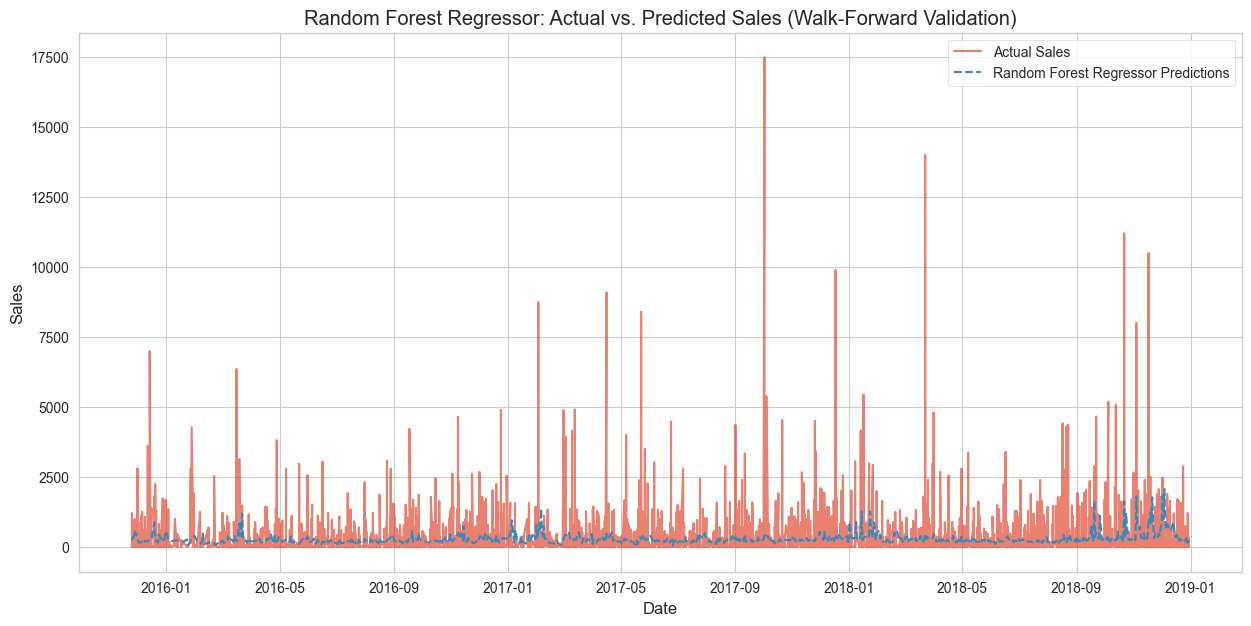

In [13]:
# Example: Plotting for Random Forest Regressor if it was run
model_to_plot = 'Random Forest Regressor'
if model_to_plot in model_predictions and model_to_plot in all_actuals:
    plt.figure(figsize=(15, 7))
    # Get the corresponding actuals and predictions
    actuals = all_actuals[model_to_plot]
    predictions = model_predictions[model_to_plot]
    
    # We need a time index for these. The `all_actuals` were collected sequentially from test folds.
    # Reconstruct the time index for the plotted data.
    # This assumes `y` is sorted and `tscv.split(X)` produces contiguous test sets over time.
    
    # Find the starting index of the first test fold
    first_test_fold_start_idx = -1
    for _, test_index in tscv.split(X):
        if first_test_fold_start_idx == -1:
            first_test_fold_start_idx = test_index[0]
        # Ensure we are using the correct slice of y for index
        # The total length of predictions should match the total length of test data elements from y
        # The y_true_model_all (which is all_actuals[model_name]) are collected in order.
        # So, we need to find the date index of y that corresponds to the start of these collections.
        
    # This logic for test_idx_for_plot is simplified and might need adjustment
    # It assumes y_true_model_all are from the latter part of the original y series
    num_predictions = len(actuals)
    test_idx_for_plot = y.index[-num_predictions:]
    
    if len(test_idx_for_plot) == len(actuals):
        plt.plot(test_idx_for_plot, actuals, label='Actual Sales', alpha=0.7)
        plt.plot(test_idx_for_plot, predictions, label=f'{model_to_plot} Predictions', linestyle='--')
        plt.title(f'{model_to_plot}: Actual vs. Predicted Sales (Walk-Forward Validation)')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()
    else:
        print(f"Could not plot for {model_to_plot}: Mismatch in length of time index and predictions/actuals.")
        print(f"  Length of time index: {len(test_idx_for_plot)}")
        print(f"  Length of actuals: {len(actuals)}")
else:
    print(f"Model '{model_to_plot}' not found in results for plotting.")